In [166]:
'''
Libraries, etc.
'''
import os
import cv2
import time
import numpy as np # linear algebra
import scipy as sp # more w/ numpy arrays
import pandas as pd # data processing
import tensorflow as tf # machine learning
import matplotlib.pyplot as plt # graph/plot
import seaborn as sns

from keras.layers import Convolution2D, Activation, BatchNormalization, GaussianNoise, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils as npu
from sklearn.metrics import confusion_matrix

from google.colab import files
uploaded = files.upload()

In [0]:
'''
Constants, Hyperparameters, etc.
'''
INPUT_DIR = './fer2013/'
INPUT_FILE = 'fer2013.csv'

EMOTION_LABELS = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
NUM_LABELS = 7

BASE_SIZE = 48
BASE_DEPTH = 1

BATCH_SIZE = 128
NUM_EPOCHS = 64

In [168]:
'''
Load & Parse Data into Training/Test Labels & Images
'''
data = pd.read_csv(INPUT_FILE)
data.head()

train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

X_train1 = np.array(list(map(str.split, train_set.pixels)), np.uint8)
X_validation1 = np.array(list(map(str.split, validation_set.pixels)), np.uint8)
X_test1 = np.array(list(map(str.split, test_set.pixels)), np.uint8)

NUM_TRAIN = len(X_train1)
NUM_VALIDATION = len(X_validation1)
NUM_TEST = len(X_test1)

X_train1 = X_train1.reshape(NUM_TRAIN, BASE_SIZE, BASE_SIZE)
X_validation1 = X_validation1.reshape(NUM_VALIDATION, BASE_SIZE, BASE_SIZE)
X_test1 = X_test1.reshape(NUM_TEST, BASE_SIZE, BASE_SIZE)

y_train = train_set.emotion
y_train = npu.to_categorical(y_train, NUM_LABELS)

y_validation = validation_set.emotion
y_validation = npu.to_categorical(y_validation, NUM_LABELS)

y_test = test_set.emotion
y_test = npu.to_categorical(y_test, NUM_LABELS)


print('Training Shape: ', X_train1.shape)
print('Validation Shape: ', X_validation1.shape)
print('Testing Shape: ', X_test1.shape)

Training Shape:  (28709, 48, 48)
Validation Shape:  (3589, 48, 48)
Testing Shape:  (3589, 48, 48)


Original Images...


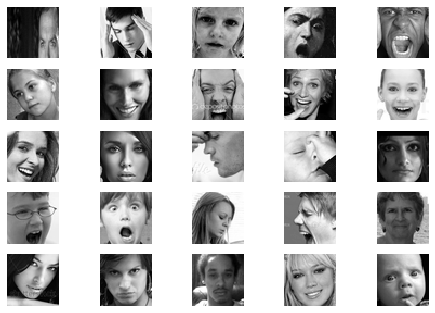

Original w/ Linear Transform to normalize pixel values...


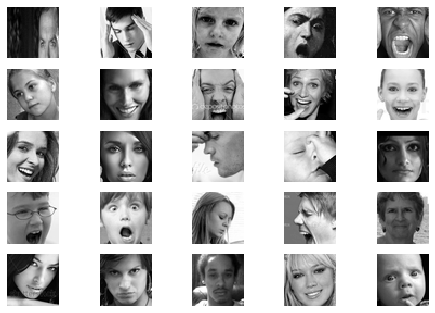

Normalized w/ Contrast Limited Adaptive Histogram Equalization


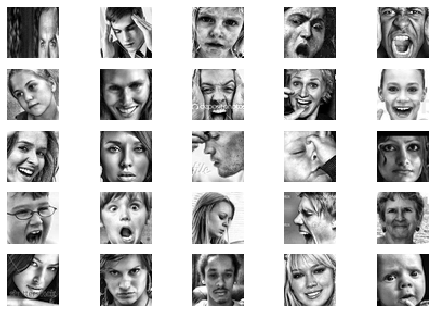

In [169]:
'''
Histogram Equalization
'''
clahe = cv2.createCLAHE(clipLimit=3.235, tileGridSize=(5,5))

X_train2 = X_train1.copy()
X_train3 = X_train1.copy()

X_validation2 = X_validation1.copy()
X_validation3 = X_validation1.copy()

X_test2 = X_test1.copy()
X_test3 = X_test1.copy()

i = 0
while (i < NUM_TRAIN):
  tMax = X_train1[i].max()
  tMin = X_train1[i].min()
  
  # Delete useless training examples
  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_train2[i] = np.multiply((X_train1[i] - tMin), tRatio)

  else:
    X_train1 = np.delete(X_train1, (i), axis=0)
    X_train2 = np.delete(X_train2, (i), axis=0)
    X_train3 = np.delete(X_train3, (i), axis=0)
    y_train = np.delete(y_train, (i), axis=0)
    NUM_TRAIN -= 1
    i -= 1
    #X_train2[i] = X_train1[i]
    
  X_train3[i] = clahe.apply(X_train2[i])
  i += 1
  
i = 0
while (i < NUM_VALIDATION):
  tMax = X_validation1[i].max()
  tMin = X_validation1[i].min()

  # Shouldn't delete validation data... skip so we don't divide by 0
  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_validation2[i] = np.multiply((X_validation1[i] - tMin), tRatio).round()
  else:
    X_validation2[i] = X_validation1[i]

  X_validation3[i] = clahe.apply(X_validation2[i])
  i += 1

i = 0
while (i < NUM_TEST):
  tMax = X_test1[i].max()
  tMin = X_test1[i].min()

  # Shouldn't delete test data... skip so we don't divide by 0
  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_test2[i] = np.multiply((X_test1[i] - tMin), tRatio).round()
  else:
    X_test2[i] = X_test1[i]
    
  X_test3[i] = clahe.apply(X_test2[i])
  i += 1

'''
Print Samples from Input Data (to confirm transforms are correct)
'''
print('Original Images...')
for x in range(1,26):
    plt.subplot(5, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test1[x], cmap='gray')
    
plt.show()

print('Original w/ Linear Transform to normalize pixel values...')
for x in range(1,26):
    plt.subplot(5, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test2[x], cmap='gray')
    
plt.show()

print('Normalized w/ Contrast Limited Adaptive Histogram Equalization')
for x in range(1,26):
    plt.subplot(5, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test3[x], cmap='gray')
    
plt.show() 

In [0]:
'''
TensorFlow Model(s)
'''
def get_model_test():
  model = Sequential()
  
  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Dropout(0.25))
  
  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Dropout(0.25))
  
  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Dropout(0.25))
  
  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
  
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  
  model.add(Dense(32))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  
  model.add(Dense(7))
  model.add(Activation('softmax'))
  
  return model


def get_model1():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model


# actual model
def get_model2():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# actual model
def get_model3():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Convolution2D(64, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(GaussianNoise(0.3))
  model.add(Dropout(0.4))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(Convolution2D(128, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(GaussianNoise(0.3))
  model.add(Dropout(0.4))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(Convolution2D(265, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(GaussianNoise(0.3))
  model.add(Dropout(0.4))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(Convolution2D(512, (3, 3), padding='same')) 
  model.add(Convolution2D(512, (1, 1), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(GaussianNoise(0.3))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(2048))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

In [0]:
'''
Metric(s)
'''
def fbeta(y_true, y_pred, threshold_shift=0):
  beta = 1
  
  y_pred = K.clip(y_pred, 0, 1)
  y_pred_bin = K.round(y_pred + threshold_shift)
  
  tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
  fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)
  
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  
  beta_sq = beta ** 2
  return K.mean((beta_sq + 1) * (precision * recall) / (beta_sq * precision + recall + K.epsilon()))
  

In [172]:
'''
Setup Model & Data Generator
'''

X_train = X_train3#np.concatenate( (np.concatenate( (X_train1, X_train2), axis=0), X_train3), axis=0)
X_validation = X_validation3
X_test = X_test3
#y_train = np.concatenate( (np.concatenate( (y_train, y_train), axis=0), y_train), axis=0)
NUM_TRAIN = len(X_train)

X_train = X_train.reshape(NUM_TRAIN,BASE_SIZE,BASE_SIZE,1).astype(np.float32)
X_validation = X_validation.reshape(NUM_VALIDATION,BASE_SIZE,BASE_SIZE,1).astype(np.float32)
X_test = X_test.reshape(NUM_TEST,BASE_SIZE,BASE_SIZE,1).astype(np.float32)

model = get_model2()
model.summary()

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    horizontal_flip=True,
    vertical_flip=False
)
datagen.fit(X_train)
datagen.fit(X_validation)

filepath = 'Model.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[fbeta, 'accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_132 (Bat (None, 48, 48, 64)        256       
_________________________________________________________________
activation_144 (Activation)  (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_133 (Bat (None, 24, 24, 128)       512       
__________

In [173]:
'''
Training
'''
train_flow = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_flow = datagen.flow(X_validation, y_validation)

history = model.fit_generator(
    train_flow,
    steps_per_epoch=NUM_TRAIN / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=NUM_VALIDATION / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

Epoch 1/64
225/224 [==============================] - 38s 169ms/step - loss: 1.6996 - fbeta: 0.1693 - acc: 0.3565 - val_loss: 1.7635 - val_fbeta: 0.2220 - val_acc: 0.3621

Epoch 00001: saving model to Model.01-0.3621.hdf5

Epoch 00001: saving model to Model.01-0.3621.hdf5
Epoch 2/64
225/224 [==============================] - 28s 123ms/step - loss: 1.3750 - fbeta: 0.2748 - acc: 0.4684 - val_loss: 1.6307 - val_fbeta: 0.3901 - val_acc: 0.4558

Epoch 00002: saving model to Model.02-0.4558.hdf5

Epoch 00002: saving model to Model.02-0.4558.hdf5
Epoch 3/64
225/224 [==============================] - 28s 123ms/step - loss: 1.2516 - fbeta: 0.3219 - acc: 0.5225 - val_loss: 1.4740 - val_fbeta: 0.2683 - val_acc: 0.4418

Epoch 00003: saving model to Model.03-0.4418.hdf5

Epoch 00003: saving model to Model.03-0.4418.hdf5
Epoch 4/64
225/224 [==============================] - 28s 122ms/step - loss: 1.1817 - fbeta: 0.3606 - acc: 0.5493 - val_loss: 1.2690 - val_fbeta: 0.2708 - val_acc: 0.5261

Epoch 000

28/28 [==============================] - 23s 809ms/step
Evaluation Loss:  1.1159392595291138
Evaluation Accuracy:  0.6648091673851013


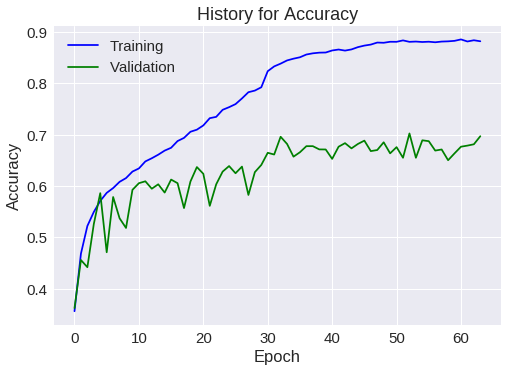

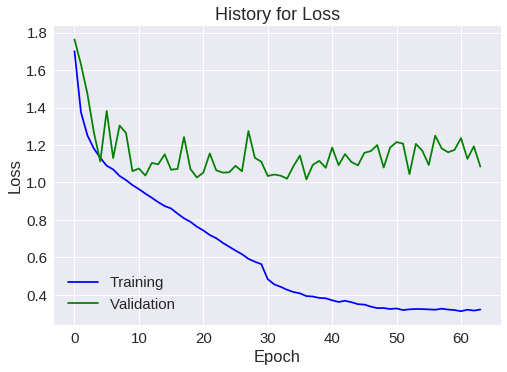

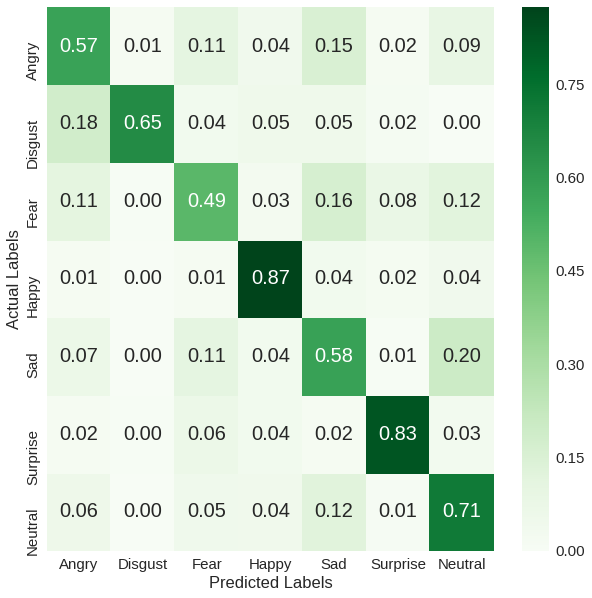

In [174]:
'''
Evaluation
'''
score = model.evaluate(X_test, y_test, steps=int(NUM_TEST / BATCH_SIZE))
print('Evaluation Loss: ', score[0])
print('Evaluation Accuracy: ', score[1])

# History of Accuracy
hist_acc = 'accuracy.png'
fig1 = plt.figure()
plt.plot(history.history['acc'], color='b', label='Training')
plt.plot(history.history['val_acc'], color='g', label='Validation')
plt.title('History for Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
fig1.savefig(hist_acc)
plt.show() 

# History of Loss
loss_acc = 'loss.png'
fig2 = plt.figure()
plt.plot(history.history['loss'], color='b', label='Training')
plt.plot(history.history['val_loss'], color='g', label='Validation')
plt.title('History for Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
fig1.savefig(loss_acc)
plt.show()

y_pred = model.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', yticklabels=EMOTION_LABELS, xticklabels=EMOTION_LABELS, vmin=0, vmax=np.max(cm_norm), fmt='.2f', annot_kws={'size': 20})
ax.set(xlabel='Predicted Labels', ylabel='Actual Labels')

plt.show()